# Classification d'images bruitées de chiffres
Louise LAM (21980795) - M2BI

## Importations

In [ ]:
# importations
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np

# keras
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.models import Sequential
from keras.utils import plot_model, to_categorical

import seaborn as sns

# sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

# tensorflow
from tensorflow.keras import optimizers

## Chargement des données



In [ ]:
drive.mount("/content/drive")
%cd  /content/drive/MyDrive/Etudes/Postbac/FAC/Master/S3/AIAO/Projet
%pwd

Mounted at /content/drive
/content/drive/MyDrive/Etudes/Postbac/FAC/Master/S3/AIAO/Projet


'/content/drive/MyDrive/Etudes/Postbac/FAC/Master/S3/AIAO/Projet'

In [ ]:
train_images = np.load("data/train_images.npy")
train_labels = np.load("data/train_labels.npy")
test_images = np.load("data/test_images.npy")
test_labels = np.load("data/test_labels.npy")

## Vérification des échantillons

In [ ]:
print('Shapes of datasets')
print(f'train: {train_images.shape}')
print(f'test: {test_images.shape}')
nb_classes = len(set(train_labels))
print(f'For {nb_classes} classes: {set(train_labels)}')

Shapes of datasets
train: (60000, 28, 28, 1)
test: (10000, 28, 28, 1)
For 10 classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


**Taille des échantillons** : les échantillons sont sufisamment remplis.

In [ ]:
print('Coherence between the number of images and labels')
print(f'train: {train_images.shape[0] == len(train_labels)}')
print(f'test: {test_images.shape[0] == len(test_labels)}')

print('\nMissing values?')
print(f'train: {np.any(np.isnan(train_labels))}')
print(f'test: {np.any(np.isnan(test_labels))}')

Coherence between the number of images and labels
train: True
test: True

Missing values?
train: False
test: False


**Cohérence entre les images et les *labels*** : Chaque image a son *label*.

In [ ]:
print('All images have the same size')
same_size_train = all(image.shape == train_images[0].shape for image in train_images)
same_size_test = all(image.shape == test_images[0].shape for image in test_images)
print(f'Train: {same_size_train} {train_images[0].shape}')
print(f'Test: {same_size_test} {test_images[0].shape}')

All images have the same size
Train: True (28, 28, 1)
Test: True (28, 28, 1)


**Taille des images** : Toutes les images (train et test) ont la même taille.

Label distribution:
All labels are represented in both train and test samples.


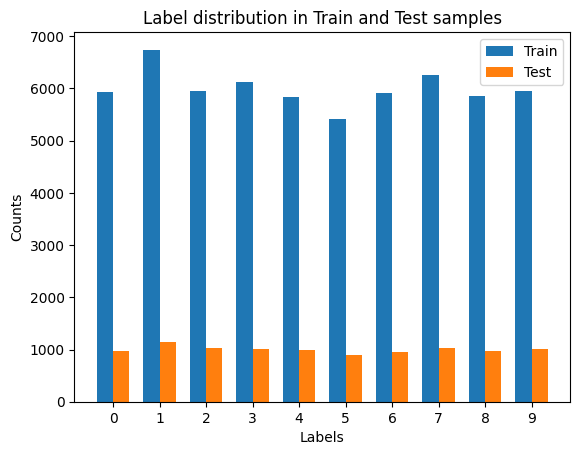

In [ ]:
def display_label_distribution():
  """Display the label distribution in both train and test samples."""

  train_labels_set, train_labels_counts = np.unique(train_labels, return_counts=True)
  test_labels_set, test_labels_counts = np.unique(test_labels, return_counts=True)

  # Check if all labels are represented in both samples
  if set(train_labels_set) != set(test_labels_set):
      print('Error: Not all labels are represented in train and test samples.')
      return
  print('All labels are represented in both train and test samples.')

  # Bars configuration
  bar_width = 0.35
  x = np.arange(len(train_labels_set))
  # Bars for train and test samples
  plt.bar(x - bar_width / 2, train_labels_counts, width=bar_width, label='Train')
  plt.bar(x + bar_width / 2, test_labels_counts, width=bar_width, label='Test')
  # Adding labels and title
  plt.xlabel('Labels')
  plt.ylabel('Counts')
  plt.title('Label distribution in Train and Test samples')
  plt.xticks(x, train_labels_set)  # Labels for the x-axis
  plt.legend()
  plt.show()

print('Label distribution:')
display_label_distribution()

**Distribution des *labels*** : Toutes les classes sont représentées de façon équilibrée dans les échantillons de train et de test.

Some train images


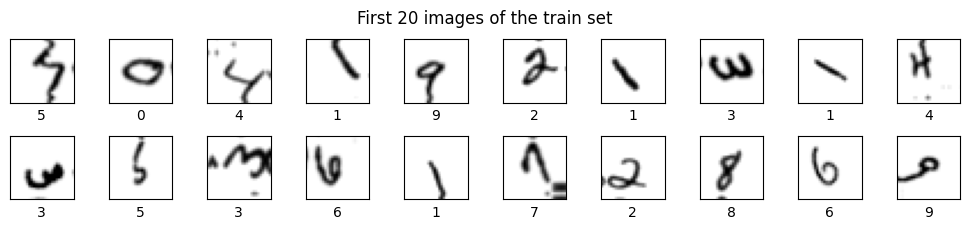


Some test images


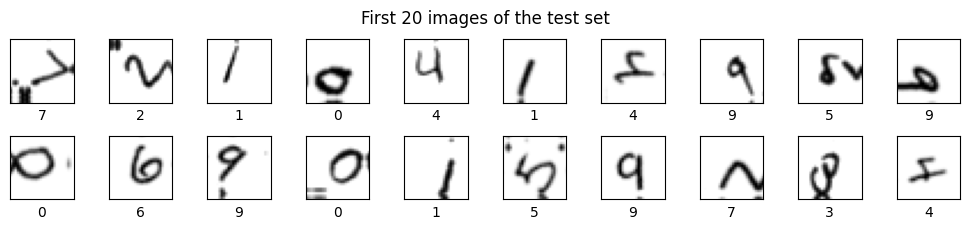

In [ ]:
def display_n_images(n: int, sample: str):
  """Display the first n images with their labels.

  Parameters
  ----------
  n : int
      Number of images to display.
  sample : str
      Either train or test.
  """
  images = train_images if sample == 'train' else test_images
  labels = train_labels if sample == 'train' else test_labels
  plt.figure(figsize=(10, 10))
  for i in range(n):  # Display the first n images
      plt.subplot(10, 10, i + 1)  # Adjusted for a 5x4 grid
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(images[i].reshape(28, 28), cmap=plt.cm.binary)  # Reshape if necessary
      plt.xlabel(labels[i])
  plt.tight_layout()  # Improve spacing
  plt.suptitle(f'First 20 images of the {sample} set')
  plt.subplots_adjust(top=0.95)
  plt.show()

print('Some train images')
display_n_images(20, 'train')
print('\nSome test images')
display_n_images(20, 'test')

## Fully Connected Neural Network (FCNN)

### Pré-traitement

In [ ]:
# Converting images to float32
train_images = train_images.astype("float32")
test_images = test_images.astype("float32")

Pour l'échantillon de test, les images sont stockées comme des entiers non signés (uint8) avec des pixels compris entre 0 et 255. Ces lignes convertissent les images en float32 pour une manipulation numérique plus précise, en particulier pour les étapes suivantes de normalisation et de calculs.

In [ ]:
# Flattening the images
num_pixels = 28 * 28  # 784
dense_train_images = train_images.reshape(train_images.shape[0], num_pixels)
dense_test_images = test_images.reshape(test_images.shape[0], num_pixels)

Les images, initiallement des matrices 2D de taille 28x28, sont redimensionnées en vecteurs de taille 784 (=28x28). C'est nécessaire pour les réseaux de neuronnes *fully connected* qui ne prennent en entrée que des vecteurs 1D.

In [ ]:
# Data normalization
dense_train_images = dense_train_images / dense_train_images.max()
dense_test_images = dense_test_images / dense_test_images.max()

Au cours de la normalisation, on fait en sorte que les pixels soient compris entre 0 et 1 au lieu de 0 et 255.

In [ ]:
# Encoding labels
train_labels_oh = to_categorical(train_labels, nb_classes)
test_labels_oh = to_categorical(test_labels, nb_classes)

On transforme aussi les *labels* (ici des entiers de 0 à 9), en vecteurs *one-hot* encodés pour que le réseau soit capable de prédire une probabilité pour chaque classe de façon indépendante.

In [ ]:
# Shuffle the data
nb_examples = dense_train_images.shape[0]  # number of examples
np.random.seed()
shuffle_index = np.random.permutation(nb_examples)
dense_train_images = dense_train_images[shuffle_index, :]
train_labels_oh = train_labels_oh[shuffle_index,]

Mélanger les données avant l'entraînement est important pour éviter que le modèle soit biaisé par l'ordre des données. Ça permet souvent d'améliorer la généralisation puisque ça garantit que le modèle ne se repose sur l'ordre des données durant l'entraînement.

### Construction du modèle

Ce modèle respecte les consignes du projet, avec cependant quelques ajustements:

- Le Dropout est placé juste après la première couche dense afin de régulariser efficacement le modèle sans affecter négativement les couches finales et la sortie.
- Le learning rate est fixé à 0,001. La réduction du learning rate n’a pas amélioré les performances. Ainsi, à performances égales, une valeur plus élevée est préférable, car elle permet une convergence plus rapide.
- La taille des batchs est de 128, ce qui reste raisonnable pour un ensemble de 60 000 images. Des batchs plus petits n’améliorent pas les performances et rallongent le temps d’entraînement.
- Le nombre d'epochs est fixé à 30. J'avais initialement choisi un nombre d'epochs plus bas, mais j'avais l'impression que le modèle sous-apprenait. J'ai donc préféré l'augmenter pour m'assurer que le modèle généralise mieux tout en veillant à ne pas sur-apprendre.

In [ ]:
def dense_model():
  """Build and compile a dense neural network model for classification.

  Returns
  -------
  Sequential
    The compiled Keras Sequential model.
  """
  # Build the model
  model = Sequential()
  model.add(Dense(256, activation="relu", input_dim=num_pixels))
  model.add(Dropout(0.3))  # 30% dropout for regularization

  # Second hidden layer with 128 neurons, ReLU activation
  model.add(Dense(128, activation='relu'))

  # Output layer with softmax activation for multi-class classification
  model.add(Dense(nb_classes, activation='softmax'))

  # Compile the model
  opt = optimizers.RMSprop(learning_rate=0.001) # RMSprop optimizer
  model.compile(loss='categorical_crossentropy',  # Cross-entropy loss function
                optimizer=opt,
                metrics=['accuracy'])  # Track accuracy during training
  return model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                     │ (None, 256)                 │         200,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

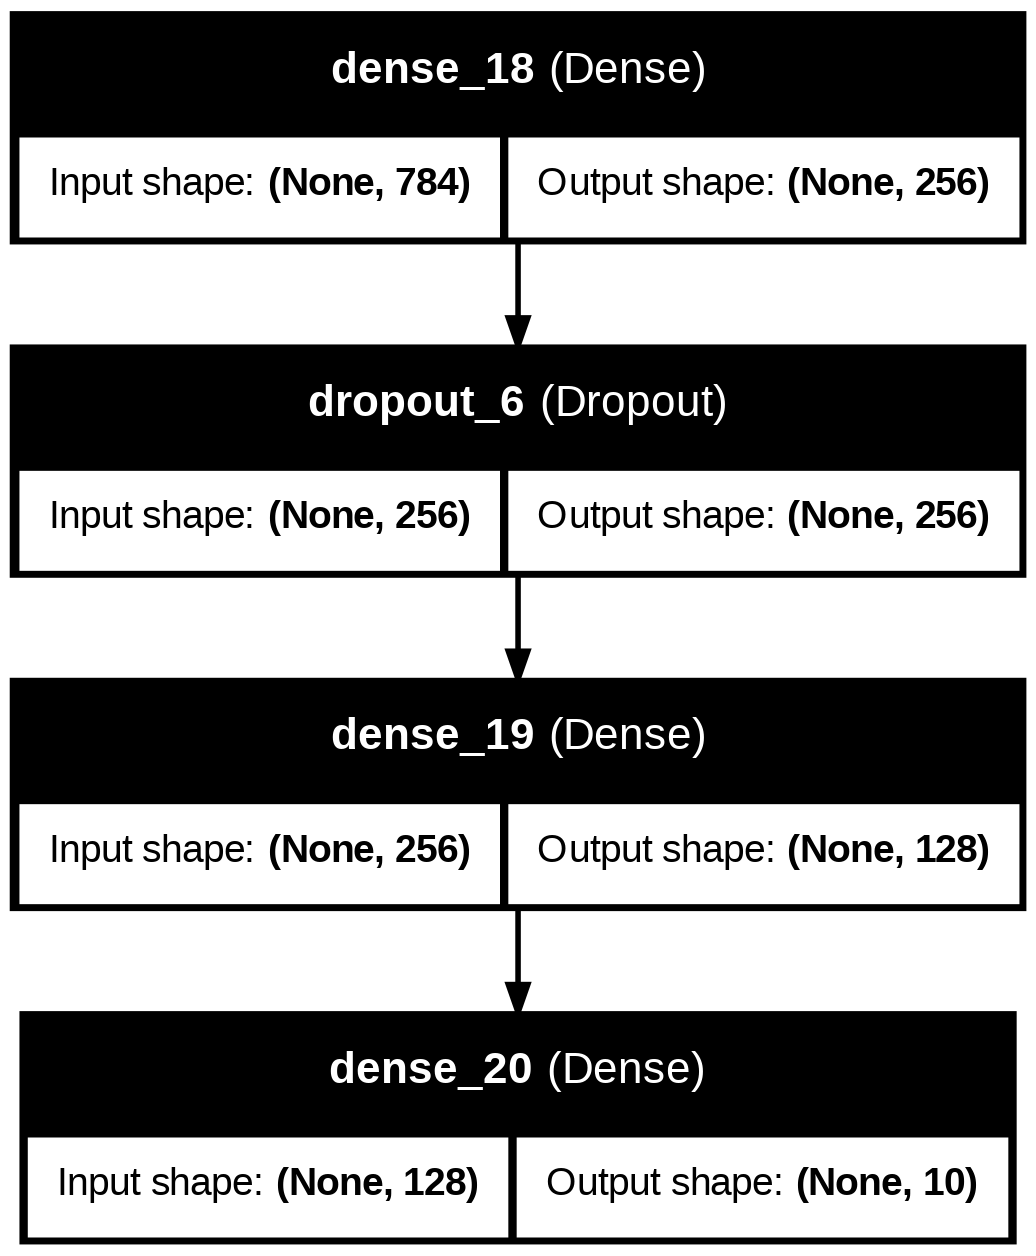

In [ ]:
dense_model = dense_model()
dense_model.summary()
plot_model(dense_model, to_file="dense_model.png", show_shapes=True, show_layer_names=True)

In [ ]:
dense_history = dense_model.fit(dense_train_images, train_labels_oh, validation_split = 0.2, epochs=30, batch_size=128)

Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.2781 - loss: 2.0111 - val_accuracy: 0.5539 - val_loss: 1.3497
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5487 - loss: 1.3529 - val_accuracy: 0.6696 - val_loss: 1.0422
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6276 - loss: 1.1258 - val_accuracy: 0.7182 - val_loss: 0.8971
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6781 - loss: 0.9859 - val_accuracy: 0.7483 - val_loss: 0.8105
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7069 - loss: 0.9076 - val_accuracy: 0.7503 - val_loss: 0.7847
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7248 - loss: 0.8352 - val_accuracy: 0.7687 - val_loss: 0.7341
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7453 - loss: 0.7960 - val_accuracy: 0.7891 - val_loss: 0.6813
Epoch 8/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7623 - loss: 0.7443 - val_accuracy: 

In [ ]:
dense_scores = dense_model.evaluate(dense_test_images, test_labels_oh)
print("Neural network accuracy: %.2f%%" % (dense_scores[1] * 100))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8460 - loss: 0.4911
Neural network accuracy: 86.27%


L'évaluation sur le jeu de test avec une précision à presque 85% et une perte plutôt faible à 0.5 montre que le modèle généralise bien sans sur-apprendre.

### Performances

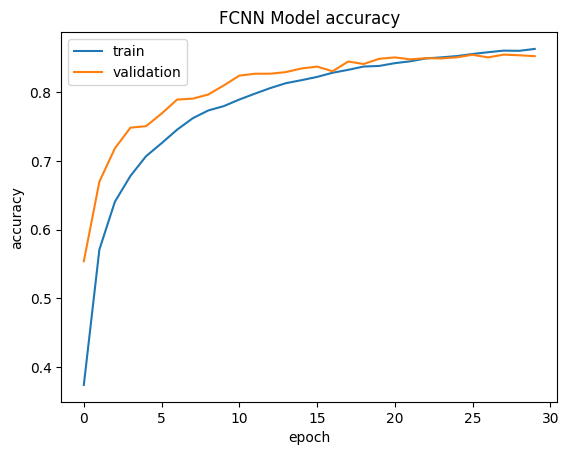

In [ ]:
#  Accuracy
plt.plot(dense_history.history["accuracy"])
plt.plot(dense_history.history["val_accuracy"])
plt.title("FCNN Model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

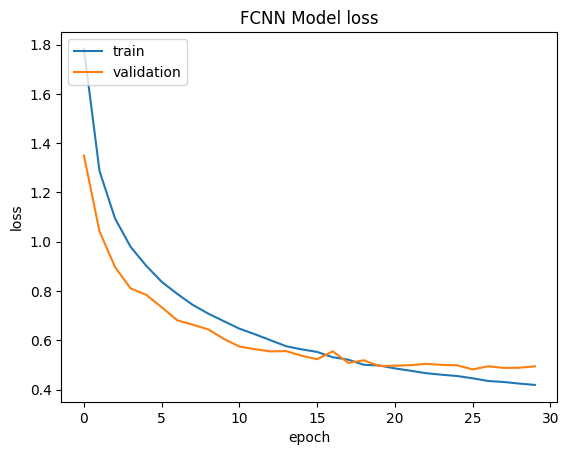

In [ ]:
# Loss
plt.plot(dense_history.history["loss"])
plt.plot(dense_history.history["val_loss"])
plt.title("FCNN Model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

Les deux échantillons ont bien appris, on a des courbes qui convergent vite. Il n’y a pas de sur apprentissage et le modèle semble capable de bien généraliser.

In [ ]:
dense_y_pred = dense_model.predict(dense_test_images)
dense_y_pred_classes = np.argmax(dense_y_pred, axis = 1)
dense_y_pred_classes

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


array([7, 2, 1, ..., 4, 8, 6])

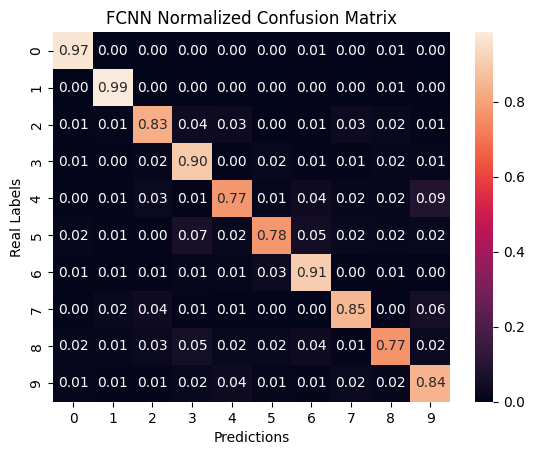

In [ ]:
sns.heatmap(confusion_matrix(test_labels, dense_y_pred_classes, normalize="true"), annot=True, fmt='.2f')
plt.title("FCNN Normalized Confusion Matrix")
plt.xlabel("Predictions")
plt.ylabel("Real Labels")
plt.show()

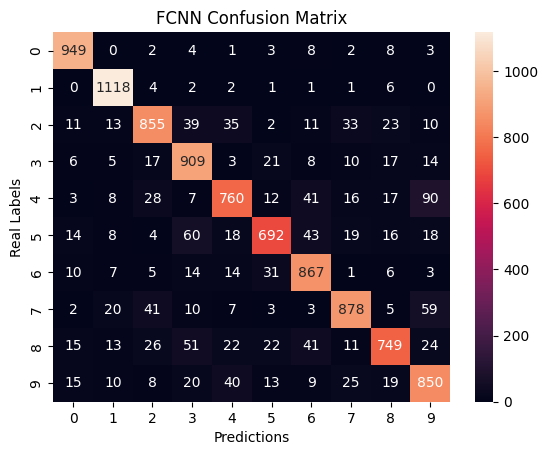

In [ ]:
sns.heatmap(confusion_matrix(test_labels, dense_y_pred_classes), annot=True, fmt='d')
plt.title("FCNN Confusion Matrix")
plt.xlabel("Predictions")
plt.ylabel("Real Labels")
plt.show()

Les matrices de confusion montrent de belles diagonales qui indiquent que la majorité des prédictions du modèle sont correctes et coïncident avec les vraies étiquettes.


### Cross Validation

In [1]:
def dense_cv():
  """Perform cross-validation on the fully connected neural network model.

  Returns
  -------
  Tuple[List, List]
    A tuple containing two lists:
    - history_list: containing training history for each fold.
    - test_scores: containing test scores for each fold.
  """
  history_list  = []
  test_scores = []
  kf = KFold(n_splits=5, shuffle=True)
  # for each fold
  for fold, (train_index, val_index) in enumerate(kf.split(dense_train_images), 1):
    X_train, X_val = dense_train_images[train_index], dense_train_images[val_index]
    y_train, y_val = train_labels_oh[train_index], train_labels_oh[val_index]
    # Build the model
    model = dense_model()
    # Training
    print(f'\n========== FOLD {fold} ==========\n')
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=128)
    # Store results
    history_list.append(history.history)
    test_scores.append(model.evaluate(dense_test_images, test_labels_oh, verbose=0))
  return history_list, test_scores

def display_kfold_train_val_results(history_list, type):
  """Display the accuracy and loss curves for each fold.

  Parameters
  ----------
  history_list : List
    List of dictionaries containing training history for each fold.
  type : str
    Either 'FCNN' or 'CNN'.
  """
  plt.figure(figsize=(12, 5))
  # Accuracies
  plt.subplot(1, 2, 1)
  for i, history in enumerate(history_list):
      plt.plot(history['accuracy'], label=f'Fold {i + 1} (train)')
      plt.plot(history['val_accuracy'], label=f'Fold {i + 1} (val)', linestyle='--')
  plt.title(f'{type} accuracy per fold')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.grid()
  # Losses
  plt.subplot(1, 2, 2)
  for i, history in enumerate(history_list):
      plt.plot(history['loss'], label=f'Fold {i + 1} (train)')
      plt.plot(history['val_loss'], label=f'Fold {i + 1} (val)', linestyle='--')
  plt.title(f'{type} loss per fold')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid()
  plt.tight_layout()
  plt.show()

def display_kfold_test_results(test_scores):
  """Display the overall accuracy and loss on test sample for each fold.

  Parameters
  ----------
  test_scores : List
    List of tuples containing test scores for each fold.
  """
  test_losses = [scores[0] for scores in test_scores]
  test_accuracies = [scores[1] * 100 for scores in test_scores]  # percentages
  mean_accuracy = np.mean(test_accuracies)
  mean_loss = np.mean(test_losses)
  sd_accuracy = np.std(test_accuracies)
  sd_loss = np.std(test_losses)

  # accuracy per fold
  plt.figure(figsize=(10, 5))
  plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, marker='o', color='b', linestyle='-', label='Test Accuracy')
  plt.axhline(y=mean_accuracy, color='g', linestyle='--', label=f'Mean Accuracy: {mean_accuracy:.2f}%')  # mean line
  plt.text(1, mean_accuracy + 0.5, f'{mean_accuracy:.2f}%', color='g', fontsize=12)  # mean value
  plt.title('Test Accuracy par Fold')
  plt.xlabel('Fold')
  plt.ylabel('Accuracy (%)')
  plt.xticks(range(1, len(test_accuracies) + 1))  # fold number
  plt.ylim(min(test_accuracies) - 1, max(test_accuracies) + 1)
  plt.grid(True)
  plt.legend()
  plt.show()

  # loss per fold
  plt.figure(figsize=(10, 5))
  plt.plot(range(1, len(test_losses) + 1), test_losses, marker='o', color='r', linestyle='-', label='Test Loss')
  plt.axhline(y=mean_loss, color='g', linestyle='--', label=f'Mean Loss: {mean_loss:.4f}')  # mean line
  plt.text(1, mean_loss + 0.01, f'{mean_loss:.4f}', color='g', fontsize=12)  # mean value
  plt.title('Test Loss par Fold')
  plt.xlabel('Fold')
  plt.ylabel('Loss')
  plt.xticks(range(1, len(test_losses) + 1)) # fold number
  plt.ylim(min(test_losses) - 0.1, max(test_losses) + 0.1)
  plt.grid(True)
  plt.legend()
  plt.show()

  print(f'Overall accuracy: {mean_accuracy:.2f} ± {sd_accuracy:.2f} %')
  print(f'Overall loss: {mean_loss:.2f} ± {sd_loss:.2f}')

In [ ]:
dense_history_list, dense_test_scores = dense_cv()


========== FOLD 1 ==========

Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.2800 - loss: 2.0145 - val_accuracy: 0.5859 - val_loss: 1.2983
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5560 - loss: 1.3272 - val_accuracy: 0.6835 - val_loss: 1.0228
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6384 - loss: 1.1101 - val_accuracy: 0.7102 - val_loss: 0.9041
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.6783 - loss: 0.9873 - val_accuracy: 0.7369 - val_loss: 0.8287
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7074 - loss: 0.8950 - val_accuracy: 0.7473 - val_loss: 0.7931
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7303 - loss: 0.8313 - val_accuracy: 0.7757 - val_loss: 0.7383
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7449 - loss: 0.7805 - val_accuracy: 0.7844 - val_loss: 0.6901
Epoch 8/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.7632 

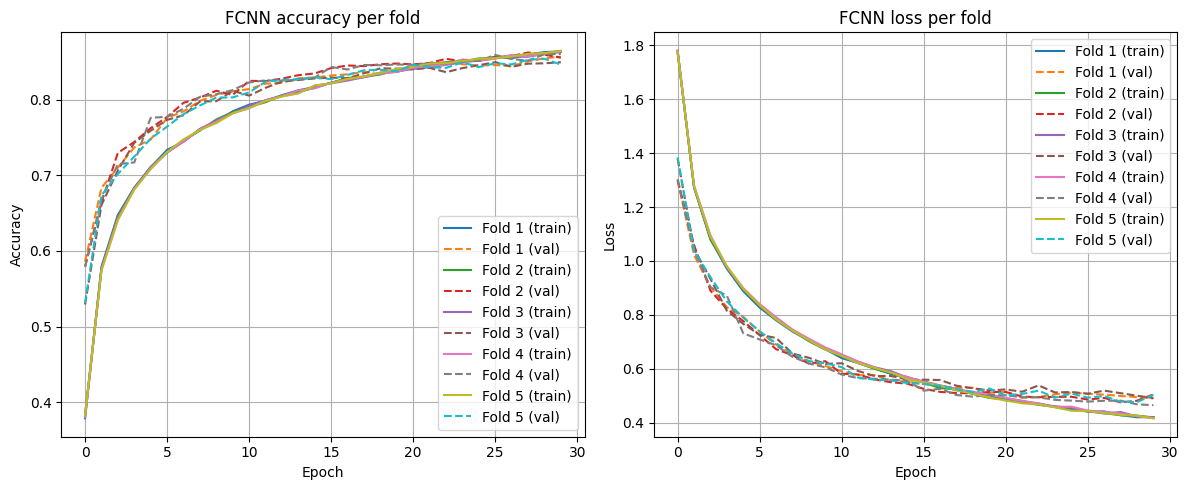

In [ ]:
display_kfold_train_val_results(dense_history_list, 'FCNN')

On retrouve les mêmes performances et on peut dire que notre modèle semble stable.

In [2]:
display_kfold_test_results(dense_test_scores)

NameError: name 'dense_test_scores' is not defined

Pour chaque fold, le modèle a très bien généralisé avec en moyenne 86% de précision et toujours 0.5 de perte.

## Convolutional Neural Network (CNN)

### Pré-traitement

In a manner similar to the preprocessing for the FCNN:

In [ ]:
# NO RESHAPING NEEDED
# Data normalization
cnn_train_images = train_images / train_images.max()
cnn_test_images = test_images / test_images.max()
# Shuffle the data
cnn_train_images = cnn_train_images[shuffle_index, :]

### Construction du modèle

Je me suis inspirée du CNN construit dans le TP MNIST Fashion. Toutefois, j'ai apporté quelques modifications :

- Optimiseur RMSprop : j'ai choisi cet optimiseur parce qu'il est aussi utilisé dans le FCNN. C'est pour pouvoir mieux comparer les performances des deux modèles.
- Learning rate : je l'ai réduit de 0.001 à 0.0005 afin d'affiner la convergence vers le minimum de la fonction de perte et d'éviter les oscillations potentielles pendant l'entraînement.
- Taille des batchs : elle est fixée à 128, ce qui reste raisonnable pour un ensemble de 60 000 images. Des batchs plus petits n'améliorent pas les performances et rallongent le temps d'entraînement.
- Nombre d'epochs : j'ai choisi 25 epochs après avoir initialement testé avec moins, mais le modèle semblait sous-apprendre. J'ai donc augmenté ce nombre pour garantir une meilleure généralisation, tout en veillant à éviter le surapprentissage.

In [ ]:
def cnn():
  """Construct and compile a convolutional neural network model.

  Returns
  -------
  Sequential
    The compiled Keras Sequential model.
  """
  # Build the model
  model = Sequential()

  # First convolution layer with 32 filters, ReLU activation
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
  model.add(MaxPooling2D((2, 2)))

  # Second convolution layer with 64 filters, ReLU activation
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2, 2)))

  # From 2D to 1D
  model.add(Flatten())

  # First dense hidden layer
  model.add(Dense(128, activation='relu', kernel_initializer='normal'))

  # Dropout to minimize overfitting
  model.add(Dropout(0.3))

  # Output layer
  model.add(Dense(10, activation='softmax'))

  opt = optimizers.RMSprop(learning_rate=0.0005) # RMSprop optimizer
  model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=opt)
  return model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

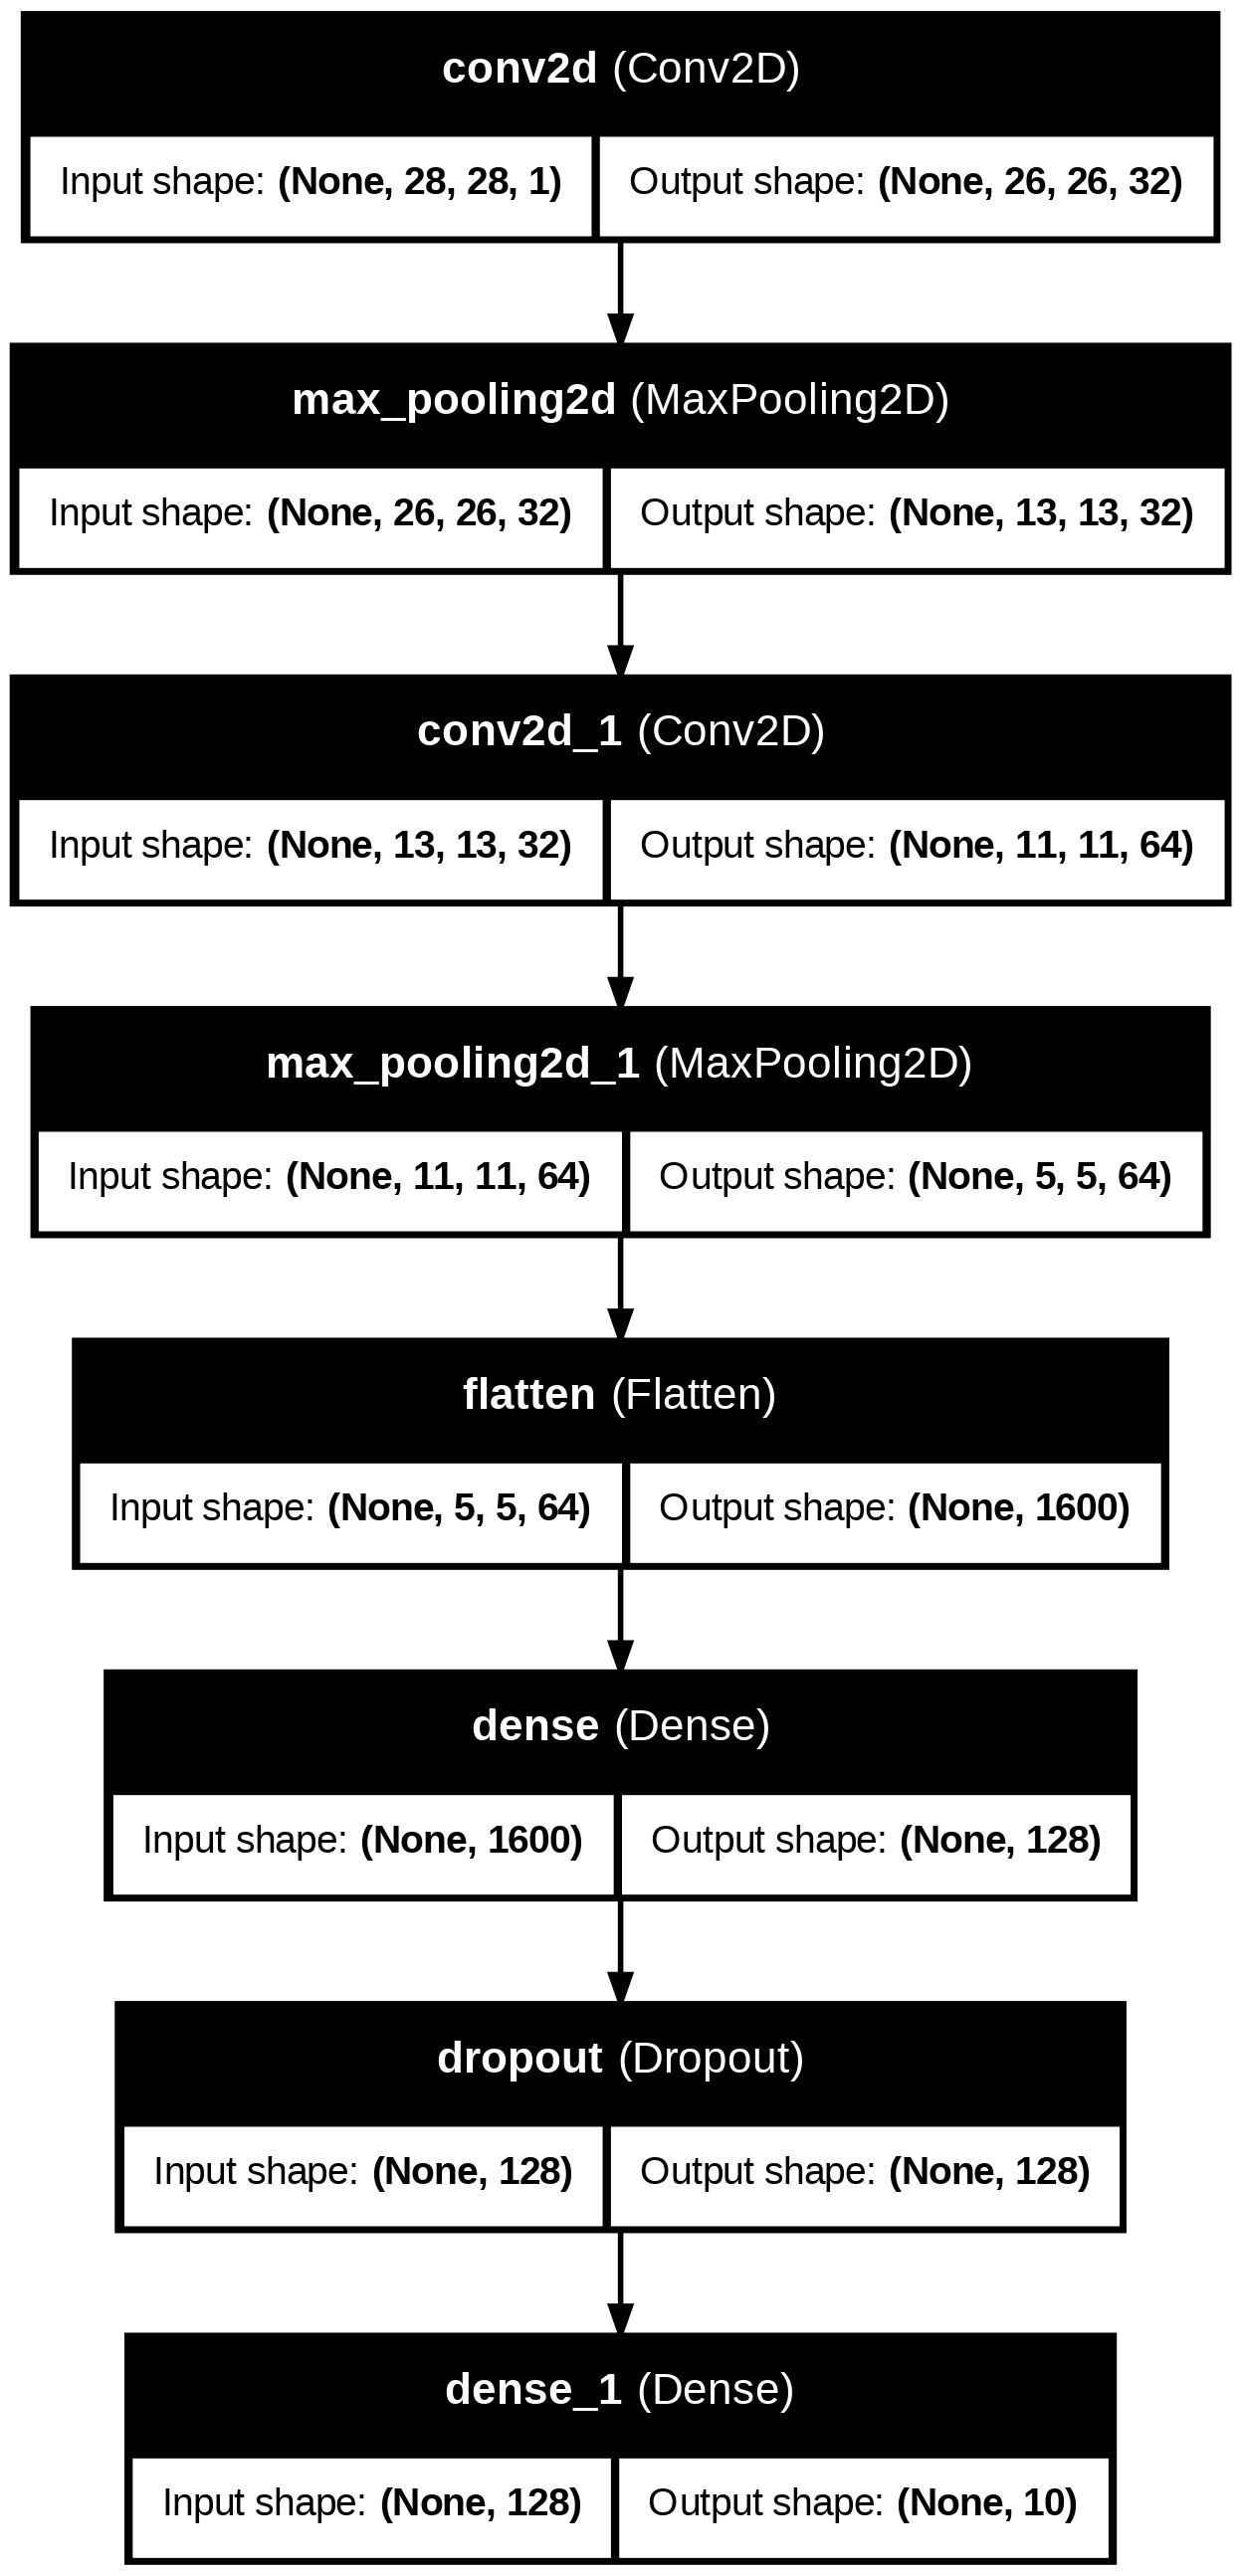

In [ ]:
cnn_model = cnn()
cnn_model.summary()
plot_model(cnn_model, to_file="cnn_model.png", show_shapes=True, show_layer_names=True)

In [ ]:
cnn_history = cnn_model.fit(cnn_train_images, train_labels_oh, validation_split=0.2, epochs=25, batch_size=128)

Epoch 1/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.3390 - loss: 1.8725 - val_accuracy: 0.7050 - val_loss: 0.9623
Epoch 2/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6848 - loss: 0.9735 - val_accuracy: 0.8167 - val_loss: 0.6266
Epoch 3/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7786 - loss: 0.6937 - val_accuracy: 0.8592 - val_loss: 0.4842
Epoch 4/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8262 - loss: 0.5513 - val_accuracy: 0.8852 - val_loss: 0.4005
Epoch 5/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8563 - loss: 0.4581 - val_accuracy: 0.9038 - val_loss: 0.3283
Epoch 6/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8771 - loss: 0.3905 - val_accuracy: 0.9115 - val_loss: 0.3030
Epoch 7/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8935 - loss: 0.3469 - val_accuracy: 0.9168 - val_loss: 0.2756
Epoch 8/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9008 - loss: 0.3100 - val_accuracy: 0.

In [ ]:
cnn_scores = cnn_model.evaluate(cnn_test_images, test_labels_oh)
print("Neural network accuracy: %.2f%%" % (cnn_scores[1] * 100))

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9413 - loss: 0.2110
Neural network accuracy: 95.03%


Très très bonne généralisation !

### Performances

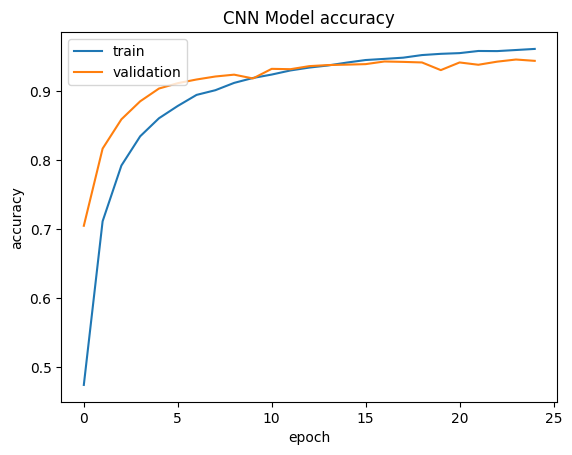

In [ ]:
#  Accuracy
plt.plot(cnn_history.history["accuracy"])
plt.plot(cnn_history.history["val_accuracy"])
plt.title("CNN Model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

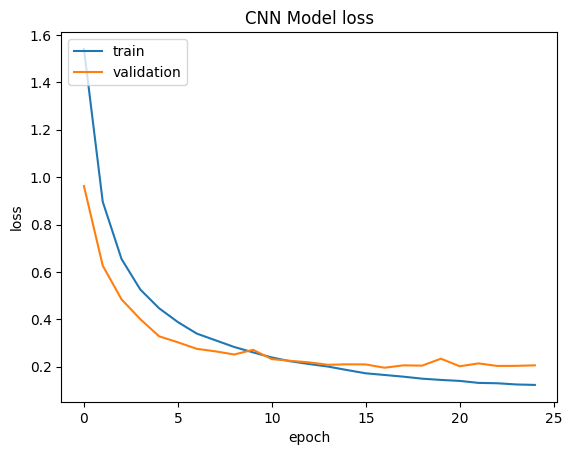

In [ ]:
# Loss
plt.plot(cnn_history.history["loss"])
plt.plot(cnn_history.history["val_loss"])
plt.title("CNN Model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

De façon analogue à l'architecture précédente, le modèle converge vite et généralise très bien sans sur apprendre.

In [ ]:
cnn_y_pred = cnn_model.predict(cnn_test_images)
cnn_y_pred_classes = np.argmax(cnn_y_pred, axis = 1)
cnn_y_pred_classes

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


array([7, 2, 1, ..., 4, 9, 6])

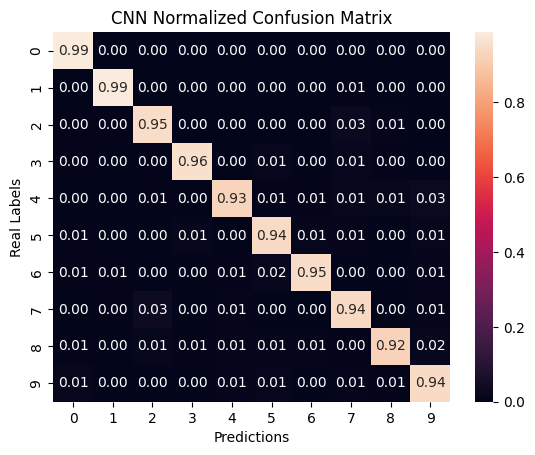

In [ ]:
sns.heatmap(confusion_matrix(test_labels, cnn_y_pred_classes, normalize="true"), annot=True, fmt='.2f')
plt.title("CNN Normalized Confusion Matrix")
plt.xlabel("Predictions")
plt.ylabel("Real Labels")
plt.show()

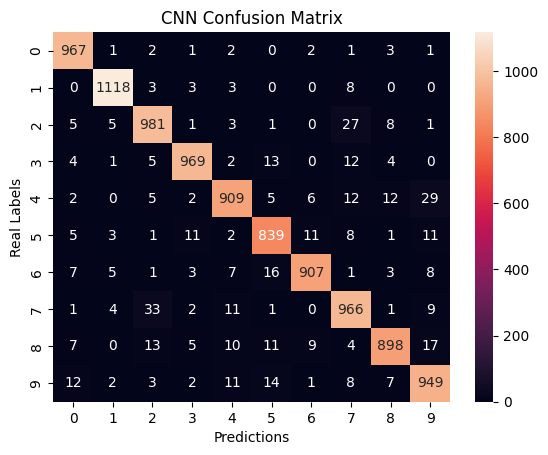

In [ ]:
sns.heatmap(confusion_matrix(test_labels, cnn_y_pred_classes), annot=True, fmt='d')
plt.title("CNN Confusion Matrix")
plt.xlabel("Predictions")
plt.ylabel("Real Labels")
plt.show()

Idem ici, quasiment toutes les étiquettes prédites étaient correctes.

### Cross Validation

In [ ]:
def cnn_cv():
  """Perform cross-validation on the convolutional neural network model.

  Returns
  -------
  Tuple[List, List]
    A tuple containing two lists:
    - history_list: containing training history for each fold.
    - test_scores: containing test scores for each fold.
  """
  history_list  = []
  test_scores = []
  kf = KFold(n_splits=5, shuffle=True)
  # for each fold
  for fold, (train_index, val_index) in enumerate(kf.split(cnn_train_images), 1):
    X_train, X_val = cnn_train_images[train_index], cnn_train_images[val_index]
    y_train, y_val = train_labels_oh[train_index], train_labels_oh[val_index]
    # build the model
    model = cnn()
    # training
    print(f'\n========== FOLD {fold} ==========\n')
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=25, batch_size=128)
    # store results
    history_list.append(history.history)
    test_scores.append(model.evaluate(cnn_test_images, test_labels_oh, verbose=0))
  return history_list, test_scores

In [ ]:
cnn_history_list, cnn_test_scores = cnn_cv()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



========== FOLD 1 ==========

Epoch 1/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.3337 - loss: 1.8898 - val_accuracy: 0.7246 - val_loss: 0.9311
Epoch 2/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6854 - loss: 0.9669 - val_accuracy: 0.8245 - val_loss: 0.6040
Epoch 3/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7817 - loss: 0.6823 - val_accuracy: 0.8621 - val_loss: 0.4609
Epoch 4/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8312 - loss: 0.5395 - val_accuracy: 0.8873 - val_loss: 0.3819
Epoch 5/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8574 - loss: 0.4478 - val_accuracy: 0.8997 - val_loss: 0.3375
Epoch 6/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8775 - loss: 0.3899 - val_accuracy: 0.9083 - val_loss: 0.3027
Epoch 7/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8940 - loss: 0.3452 - val_accuracy: 0.9119 - val_loss: 0.2905
Epoch 8/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9073 -

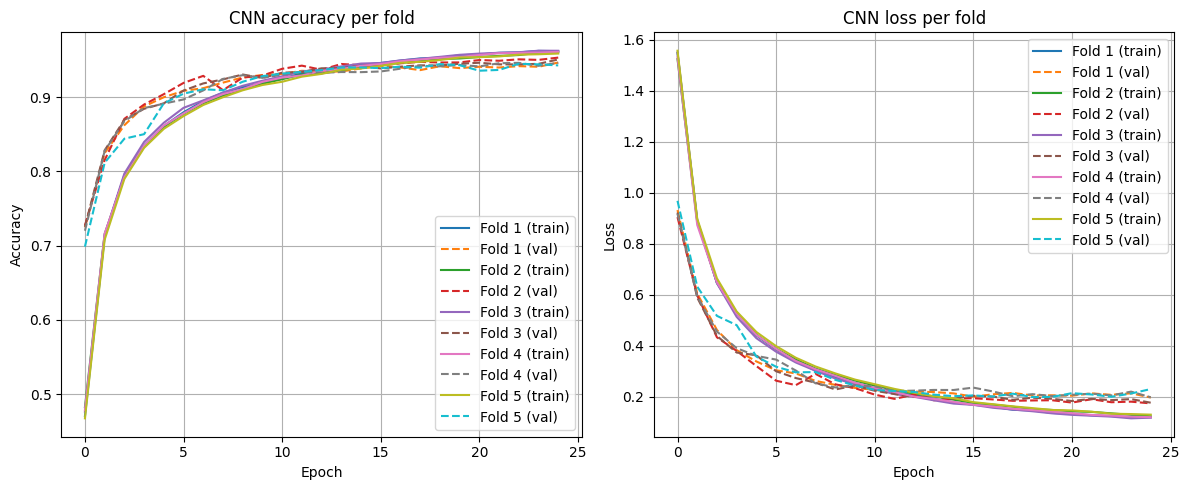

In [ ]:
display_kfold_train_val_results(cnn_history_list, 'CNN')

Et encore une fois, la cross validation montre que le modèle est stable.

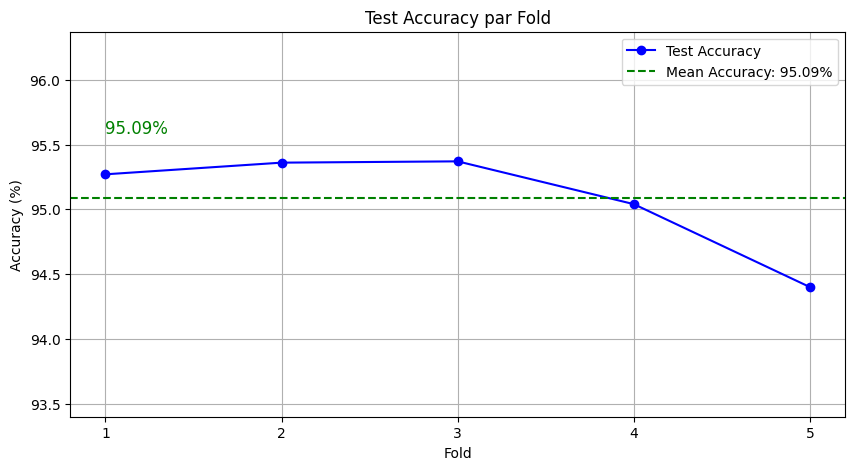

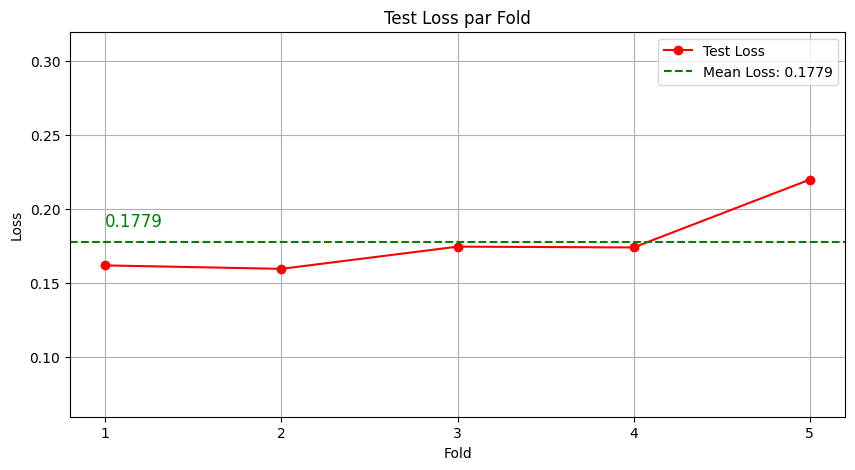

In [ ]:
display_kfold_test_results(cnn_test_scores)

Elle confirme aussi nos performances avec une excellente accuracy moyenne de 95% et une très faible loss à travers les évaluations par le jeu de test.

## Conclusion

| **Métrique**            | **FCNN** | **CNN** |
|-------------------------|----------|---------|
| Accuracy (%)            | 86.25    | 95.09   |
| Loss                    | 0.46     | 0.18    |
| Temps d'exécution (s)   | 137      | 60      |


En somme, ici on peut dire qu'à la fois en termes d'accuracy, de loss mais aussi de temps d'exécution, c'est l'architecture du réseau neuronal convolutionnel qui a de meilleures performances.